In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re

In [0]:
torch.cuda.is_available()

True

In [0]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['cardboard', 'plastic', 'glass', '.DS_Store', 'trash', 'metal', 'paper']

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [0]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [0]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [0]:
torch.cuda.empty_cache()

In [0]:
learn = cnn_learner(data,models.resnet101,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
learn.fit_one_cycle(30,max_lr=slice(5e-04,9e-04))

epoch,train_loss,valid_loss,error_rate,time
0,1.975516,0.950266,0.326984,02:29
1,1.280834,0.588602,0.204762,02:13
2,1.003060,0.473089,0.163492,02:13
3,0.723649,0.462252,0.149206,02:13
4,0.665609,0.369039,0.115873,02:13
5,0.574534,0.359355,0.104762,02:13
6,0.590391,0.429466,0.126984,02:13
7,0.424609,0.373233,0.112698,02:13
8,0.385741,0.311128,0.096825,02:13
9,0.338857,0.255307,0.080952,02:13


In [0]:
learn.save('96')

In [0]:
## delete everything when you're done to save space
#shutil.rmtree("data")
#shutil.rmtree('dataset-resized')

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)


In [0]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])


In [0]:
correct = 0
for i in range(len(y)):
    if y[i] == yhat[i]:
        correct += 1
print(correct/len(y))

0.9464566929133859


In [0]:
interp = ClassificationInterpretation.from_learner(learn)
print(interp.confusion_matrix())

[[ 96   0   0   5   0   0]
 [  0 119   2   1   3   0]
 [  0   1 100   0   1   0]
 [  3   0   0 144   0   1]
 [  0   3   4   3 108   2]
 [  1   0   0   3   0  30]]


In [0]:
cm = interp.confusion_matrix()
dico_classes = {0: ["cardboard"], 1:["glass"], 2:["metal"], 3:["paper"], 4:["plastic"], 5:["trash"]}

cm_list = []

for i in range(6):
  dico_cm = {"TP": 0, "TN": 0, "FP": 0, "FN": 0}
  dico_cm["TP"] = cm[i,i]
  fn = 0
  fp = 0
  for j in range(6):
    if i!=j:
      fn+=cm[i][j]
      fp+=cm[j][i]
  dico_cm["TN"] = cm.sum() - fn - fp - dico_cm["TP"]
  dico_cm["FP"] = fp
  dico_cm["FN"] = fn
  dico_classes[i].append(dico_cm)

mcc_list = []
for i in range(6):
  mcc = dico_classes[i][1]
  mcc_list.append((mcc["TP"]*mcc["TN"] - mcc["FP"]*mcc["FN"])/np.sqrt((mcc["TP"]+mcc["FP"])*(mcc["TP"]+mcc["FN"])*(mcc["TN"]+mcc["FP"])*(mcc["TN"]+mcc["FN"])))
print(mcc_list)

[0.9467421339507643, 0.94984467680595, 0.9541903727182284, 0.9312073252501694, 0.9163112959562265, 0.8897667613779562]


In [0]:
data_no_augm = ImageDataBunch.from_folder(path,test="test",bs=16)
learn2 = cnn_learner(data_no_augm, models.resnet101, metrics = error_rate)

In [0]:
learn2.fit_one_cycle(30,max_lr=slice(5e-04,9e-04))

epoch,train_loss,valid_loss,error_rate,time
0,1.752836,0.739566,0.253968,02:12
1,1.129375,0.453864,0.146032,02:13
2,0.727846,0.363932,0.112698,02:12
3,0.510786,0.353821,0.120635,02:13
4,0.429158,0.400652,0.106349,02:12
5,0.344865,0.328244,0.087302,02:13
6,0.279917,0.264393,0.090476,02:12
7,0.244286,0.384130,0.111111,02:12
8,0.223341,0.326422,0.093651,02:12
9,0.228003,0.376473,0.112698,02:12


In [0]:
preds = learn2.get_preds(ds_type=DatasetType.Test)

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

correct = 0
for i in range(len(y)):
    if y[i] == yhat[i]:
        correct += 1
print(correct/len(y))

0.937007874015748


In [0]:
interp2 = ClassificationInterpretation.from_learner(learn2)
cm = interp2.confusion_matrix()
dico_classes = {0: ["cardboard"], 1:["glass"], 2:["metal"], 3:["paper"], 4:["plastic"], 5:["trash"]}

cm_list = []

for i in range(6):
  dico_cm = {"TP": 0, "TN": 0, "FP": 0, "FN": 0}
  dico_cm["TP"] = cm[i,i]
  fn = 0
  fp = 0
  for j in range(6):
    if i!=j:
      fn+=cm[i][j]
      fp+=cm[j][i]
  dico_cm["TN"] = cm.sum() - fn - fp - dico_cm["TP"]
  dico_cm["FP"] = fp
  dico_cm["FN"] = fn
  dico_classes[i].append(dico_cm)

mcc_list_no_augm = []
for i in range(6):
  mcc = dico_classes[i][1]
  mcc_list_no_augm.append((mcc["TP"]*mcc["TN"] - mcc["FP"]*mcc["FN"])/np.sqrt((mcc["TP"]+mcc["FP"])*(mcc["TP"]+mcc["FN"])*(mcc["TN"]+mcc["FP"])*(mcc["TN"]+mcc["FN"])))
print(mcc_list_no_augm)

[0.9410432536637406, 0.9297623831105812, 0.9420331620535666, 0.9511657582008919, 0.8726439565924299, 0.8020676480996135]


[5 4 2 1 3 0]


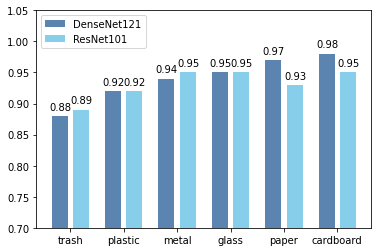

In [0]:
import matplotlib.pyplot as plt
import numpy as np
dico_classes = {0: ["cardboard"], 1:["glass"], 2:["metal"], 3:["paper"], 4:["plastic"], 5:["trash"]}
mcc_list = [0.98, 0.95, 0.94, 0.97, 0.92, 0.88]

mcc_sorted = np.argsort(np.array(mcc_list))
print(mcc_sorted)
N = 6

ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind-0.05, sorted(mcc_list), width, color='#5B84B1FF')

mcc_list_no_augm = [0.95, 0.95, 0.95, 0.93, 0.92, 0.89]

mcc_list_no_augm_follow = []
for i in range(6):
  mcc_list_no_augm_follow.append(mcc_list_no_augm[mcc_sorted[i]])

rects2 = ax.bar(ind+width+0.05, mcc_list_no_augm_follow, width, color='#87CEEB')

for b in rects1:
    yval = b.get_height()
    plt.text(b.get_x()-0.05, yval+0.01, np.round(yval,2))

for b in rects2:
  yval = b.get_height()
  plt.text(b.get_x()-0.05, yval+0.01, np.round(yval,2))
# add some
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind + width / 2)
classes = [dico_classes[i][0] for i in mcc_sorted]
ax.set_xticklabels( classes )

ax.legend( (rects1[0], rects2[0]), ('DenseNet121', 'ResNet101') , loc = 'upper left')

axes = plt.gca()

axes.set_ylim([0.7,1.05])

plt.savefig("compare_mcc_resnet.png")

In [0]:
learn2 = cnn_learner(data,models.resnet18,metrics=error_rate).to_fp16()

learn2.lr_find()
learn2.recorder.plot()

In [0]:
learn2.fit_one_cycle(20, max_lr=2.5e-03)

In [0]:
learn2.lr_find()

In [0]:
learn2.recorder.plot()

In [0]:
learn2.fit_one_cycle(4, max_lr=2e-05)

In [0]:
learn3 = cnn_learner(data,models.vgg11_bn,metrics=error_rate).to_fp16()

In [0]:
learn3.lr_find()
learn3.recorder.plot()

In [0]:
learn3.fit_one_cycle(20, max_lr=5e-03)

In [0]:
learn3.lr_find()
learn3.recorder.plot()

In [0]:
learn3.fit_one_cycle(10, max_lr=5e-03)

In [0]:
learn4 = cnn_learner(data,models.alexnet,metrics=error_rate).to_fp16()

In [0]:
learn4.lr_find()
learn4.recorder.plot()

In [0]:
learn4.fit_one_cycle(20, max_lr=5e-03)